In [29]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import seaborn as sns
import itertools as it
import pulp
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool


sys.path.append(os.path.join(os.getcwd(), 'code'))
from spatial_generation import Spatial, GroupSpatial
from elections import SNTV,Bloc,STV,Borda, ChamberlinCourant, Monroe, GreedyCC, PluralityVeto, SMRD, OMRD, DMRD
from tools import cost, best_group_cost, worst_group_cost, representativeness, representativeness_ratio, remove_candidates, borda_matrix, group_representation, max_group_representation
from election_sampling import election_sample, samples

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Colors!
pal = sns.color_palette("hls", 8)
tab20_colors = plt.cm.tab20.colors

# Group Representation

In [59]:
# Choose number of voters n
# And the number of candidates m
n = 10000
m = 20

# And the number of winners for the election
k = 4

#### 2 Party

In [60]:
# Means for each of the 4 Gaussian distributions
means = [[0, -1.5], [0, 1.5]]
stds = [0.5, 0.5]  # Standard deviations for each Gaussian
two_party_G = [5000,5000]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(two_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

two_party_generator = GroupSpatial(m = m, g = len(two_party_G),
                    voter_dists = [np.random.normal]*len(two_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [61]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = two_party_generator.generate(two_party_G)

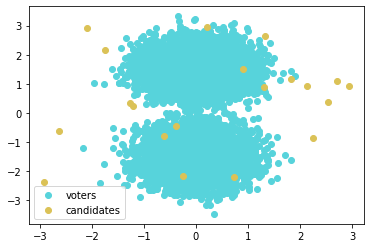

In [62]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### 4 Party

In [34]:
# Means for each of the 4 Gaussian distributions
means = [[-2, 0], [2, 0], [0, 2], [0, -2]]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Gaussian
four_party_G = [25, 25, 25, 25]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(four_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

four_party_generator = GroupSpatial(m = m, g = len(four_party_G),
                    voter_dists = [np.random.normal]*len(four_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [68]:
group_sizes = [[100 - i, i] for i in range(0, 105, 5)]

In [69]:
group_sizes

[[100, 0],
 [95, 5],
 [90, 10],
 [85, 15],
 [80, 20],
 [75, 25],
 [70, 30],
 [65, 35],
 [60, 40],
 [55, 45],
 [50, 50],
 [45, 55],
 [40, 60],
 [35, 65],
 [30, 70],
 [25, 75],
 [20, 80],
 [15, 85],
 [10, 90],
 [5, 95],
 [0, 100]]

In [35]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = four_party_generator.generate(four_party_G)

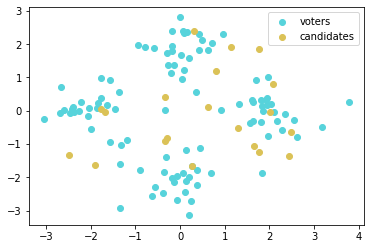

In [36]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [63]:
'''
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{}, ChamberlinCourant:{}, GreedyCC:{}, Monroe:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe, 
                  PluralityVeto, SMRD, OMRD, DMRD]
'''

elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{},GreedyCC:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}
elections_list = [SNTV, Bloc, STV, Borda, GreedyCC,
                  PluralityVeto, SMRD, OMRD, DMRD]

n_samples = 10

In [64]:
#f = 'data/2party.npz'


start = time.time()
results_list = samples(10, two_party_generator, elections_dict, [two_party_G], k, dim = 2, filename = None)
end = time.time()
print(end - start)
result_dict = results_list[0]

'''
loaded_data = np.load(f)
result_dict = {key: loaded_data[key] for key in loaded_data.files}

result_dict['DMRD'] = result_dict.pop('RandomDictator')
result_dict['OMRD'] = result_dict.pop('RandomDictator2')
'''
#result_dict['CC'] = result_dict.pop('ChamberlinCourant')

46.43234395980835


"\nloaded_data = np.load(f)\nresult_dict = {key: loaded_data[key] for key in loaded_data.files}\n\nresult_dict['DMRD'] = result_dict.pop('RandomDictator')\nresult_dict['OMRD'] = result_dict.pop('RandomDictator2')\n"

In [106]:
#n_samples = 10
#f = 'data/4party.npz'
#loaded_data = np.load(f)
#result_dict = {key: loaded_data[key] for key in loaded_data.files}

In [ ]:
fig, axes = plt.subplots(len(elections_list) + 1, 3, figsize=(10, 24), dpi = 200)
plt.rcParams.update({'font.size': 12})

for i, ax in enumerate(axes.flat):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

vc = pal[5]
cc = pal[4]
wc = pal[7]

sample_idx = 1
voter_example = result_dict['voters'][sample_idx]
voter_stack = pd.DataFrame(np.vstack(result_dict['voters']), columns = ['x','y'])
voter_stack = voter_stack.sample(frac=0.001, random_state=42)

# Baseline
candidate_example = result_dict['candidates'][sample_idx]
candidate_stack = pd.DataFrame(np.vstack(result_dict['candidates']), columns = ['x','y'])
candidate_stack = candidate_stack.sample(frac=0.001, random_state=42)
sns.kdeplot(data=voter_stack, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, alpha = 0.7, ax = axes[0][0])
sns.kdeplot(data=candidate_stack, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.7, ax = axes[0][0])
axes[0][0].set_title('KDE')
axes[0][0].set_ylabel('')
axes[0][0].set_xlabel('')

axes[0][1].scatter(voter_stack.iloc[:,0], voter_stack.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.5, s = 10)
axes[0][1].scatter(candidate_stack.iloc[:,0], candidate_stack.iloc[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.6, s = 10)
axes[0][1].set_title('Scatter')

axes[0][2].scatter(voter_example[:,0], voter_example[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.5, s = 30)
axes[0][2].scatter(candidate_example[:,0], candidate_example[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].set_title('Example')


for i,E in enumerate(elections_list):
    name = E.__name__
    name_label = name
    if name == 'RandomDictator':
        name = 'DMRD'
        name_label = name
    if name == 'RandomDictator2':
        name = 'OMRD'
        name_label = name
        
    #if name == 'ChamberlinCourant':
    #    name = 'CC'
    #    name_label = name
    #if name == 'PRD':
    #    name_label = r'$(\frac{1}{m - 1}, 2)$-RD'
        
    ax_idx = i + 1

    winner_example = result_dict[name][sample_idx]
    winner_stack = pd.DataFrame(np.vstack(result_dict[name]), columns = ['x','y'])
    winner_stack = winner_stack.sample(frac=0.001, random_state=42)
    
    sns.kdeplot(data=voter_stack, x='x', y='y', color = vc, fill=False,
                thresh=0.1, levels=10, alpha = 0.7, ax = axes[ax_idx][0])
    sns.kdeplot(data=winner_stack, x='x', y='y', color = wc, fill=False,
                thresh=0.1, levels=10, alpha = 0.7, ax = axes[ax_idx][0])
    
    axes[ax_idx][0].set_ylabel(name_label)
    axes[ax_idx][0].set_xlabel('')
    
    axes[ax_idx][1].scatter(voter_stack.iloc[:,0], voter_stack.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.5, s = 10)
    axes[ax_idx][1].scatter(winner_stack.iloc[:,0], winner_stack.iloc[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.6, s = 10)

    axes[ax_idx][2].scatter(voter_example[:,0], voter_example[:,1],
                       facecolors = vc, edgecolors = 'none', alpha = 0.5, s = 30)
    axes[ax_idx][2].scatter(winner_example[:,0], winner_example[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.9, s = 30)
     

legend_elements = [Line2D([0], [0], marker = 'o', color=vc, lw=2, label='voters'),
                   Line2D([0], [0], marker = 'o', color=cc, lw=2, label='candidates'),
                  Line2D([0], [0], marker = 'o', color=wc, lw=2, label='winners')]

fig.legend(fontsize = 12, handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=3)

#plt.savefig('figures/2party.png', bbox_inches='tight')

### Representativeness

In [25]:
# USE KNOWN GROUP LABELS:
avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
avg_represent['DMRD'] = avg_represent.pop('RandomDictator')
avg_represent['OMRD'] = avg_represent.pop('RandomDictator2')
#avg_represent['CC'] = avg_represent.pop('ChamberlinCourant')

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        if name == 'RandomDictator':
            name = 'DMRD'
        elif name == 'RandomDictator2':
            name = 'OMRD'
        #elif name == 'ChamberlinCourant':
        #    name = 'CC'
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent[name][i] = represent
        
represent_data = [values for values in avg_represent.values()]
represent_labels = [name for name in avg_represent.keys()]

# TREATS EVERYONE AS A SINGLE GROUP:
avg_represent1 = {e.__name__:np.zeros(n_samples) for e in elections_list}
avg_represent1['DMRD'] = avg_represent1.pop('RandomDictator')
avg_represent1['OMRD'] = avg_represent1.pop('RandomDictator2')
#avg_represent1['CC'] = avg_represent1.pop('ChamberlinCourant')

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    labels = np.zeros(len(labels))
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        if name == 'RandomDictator':
            name = 'DMRD'
        elif name == 'RandomDictator2':
            name = 'OMRD'
        #elif name == 'ChamberlinCourant':
        #    name = 'CC'
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent1[name][i] = represent
        
represent_data1 = [values for values in avg_represent1.values()]
represent_labels1 = [name for name in avg_represent1.keys()]

ylimit = max(max([np.max(r) for r in represent_data]), max([np.max(r) for r in represent_data1]))

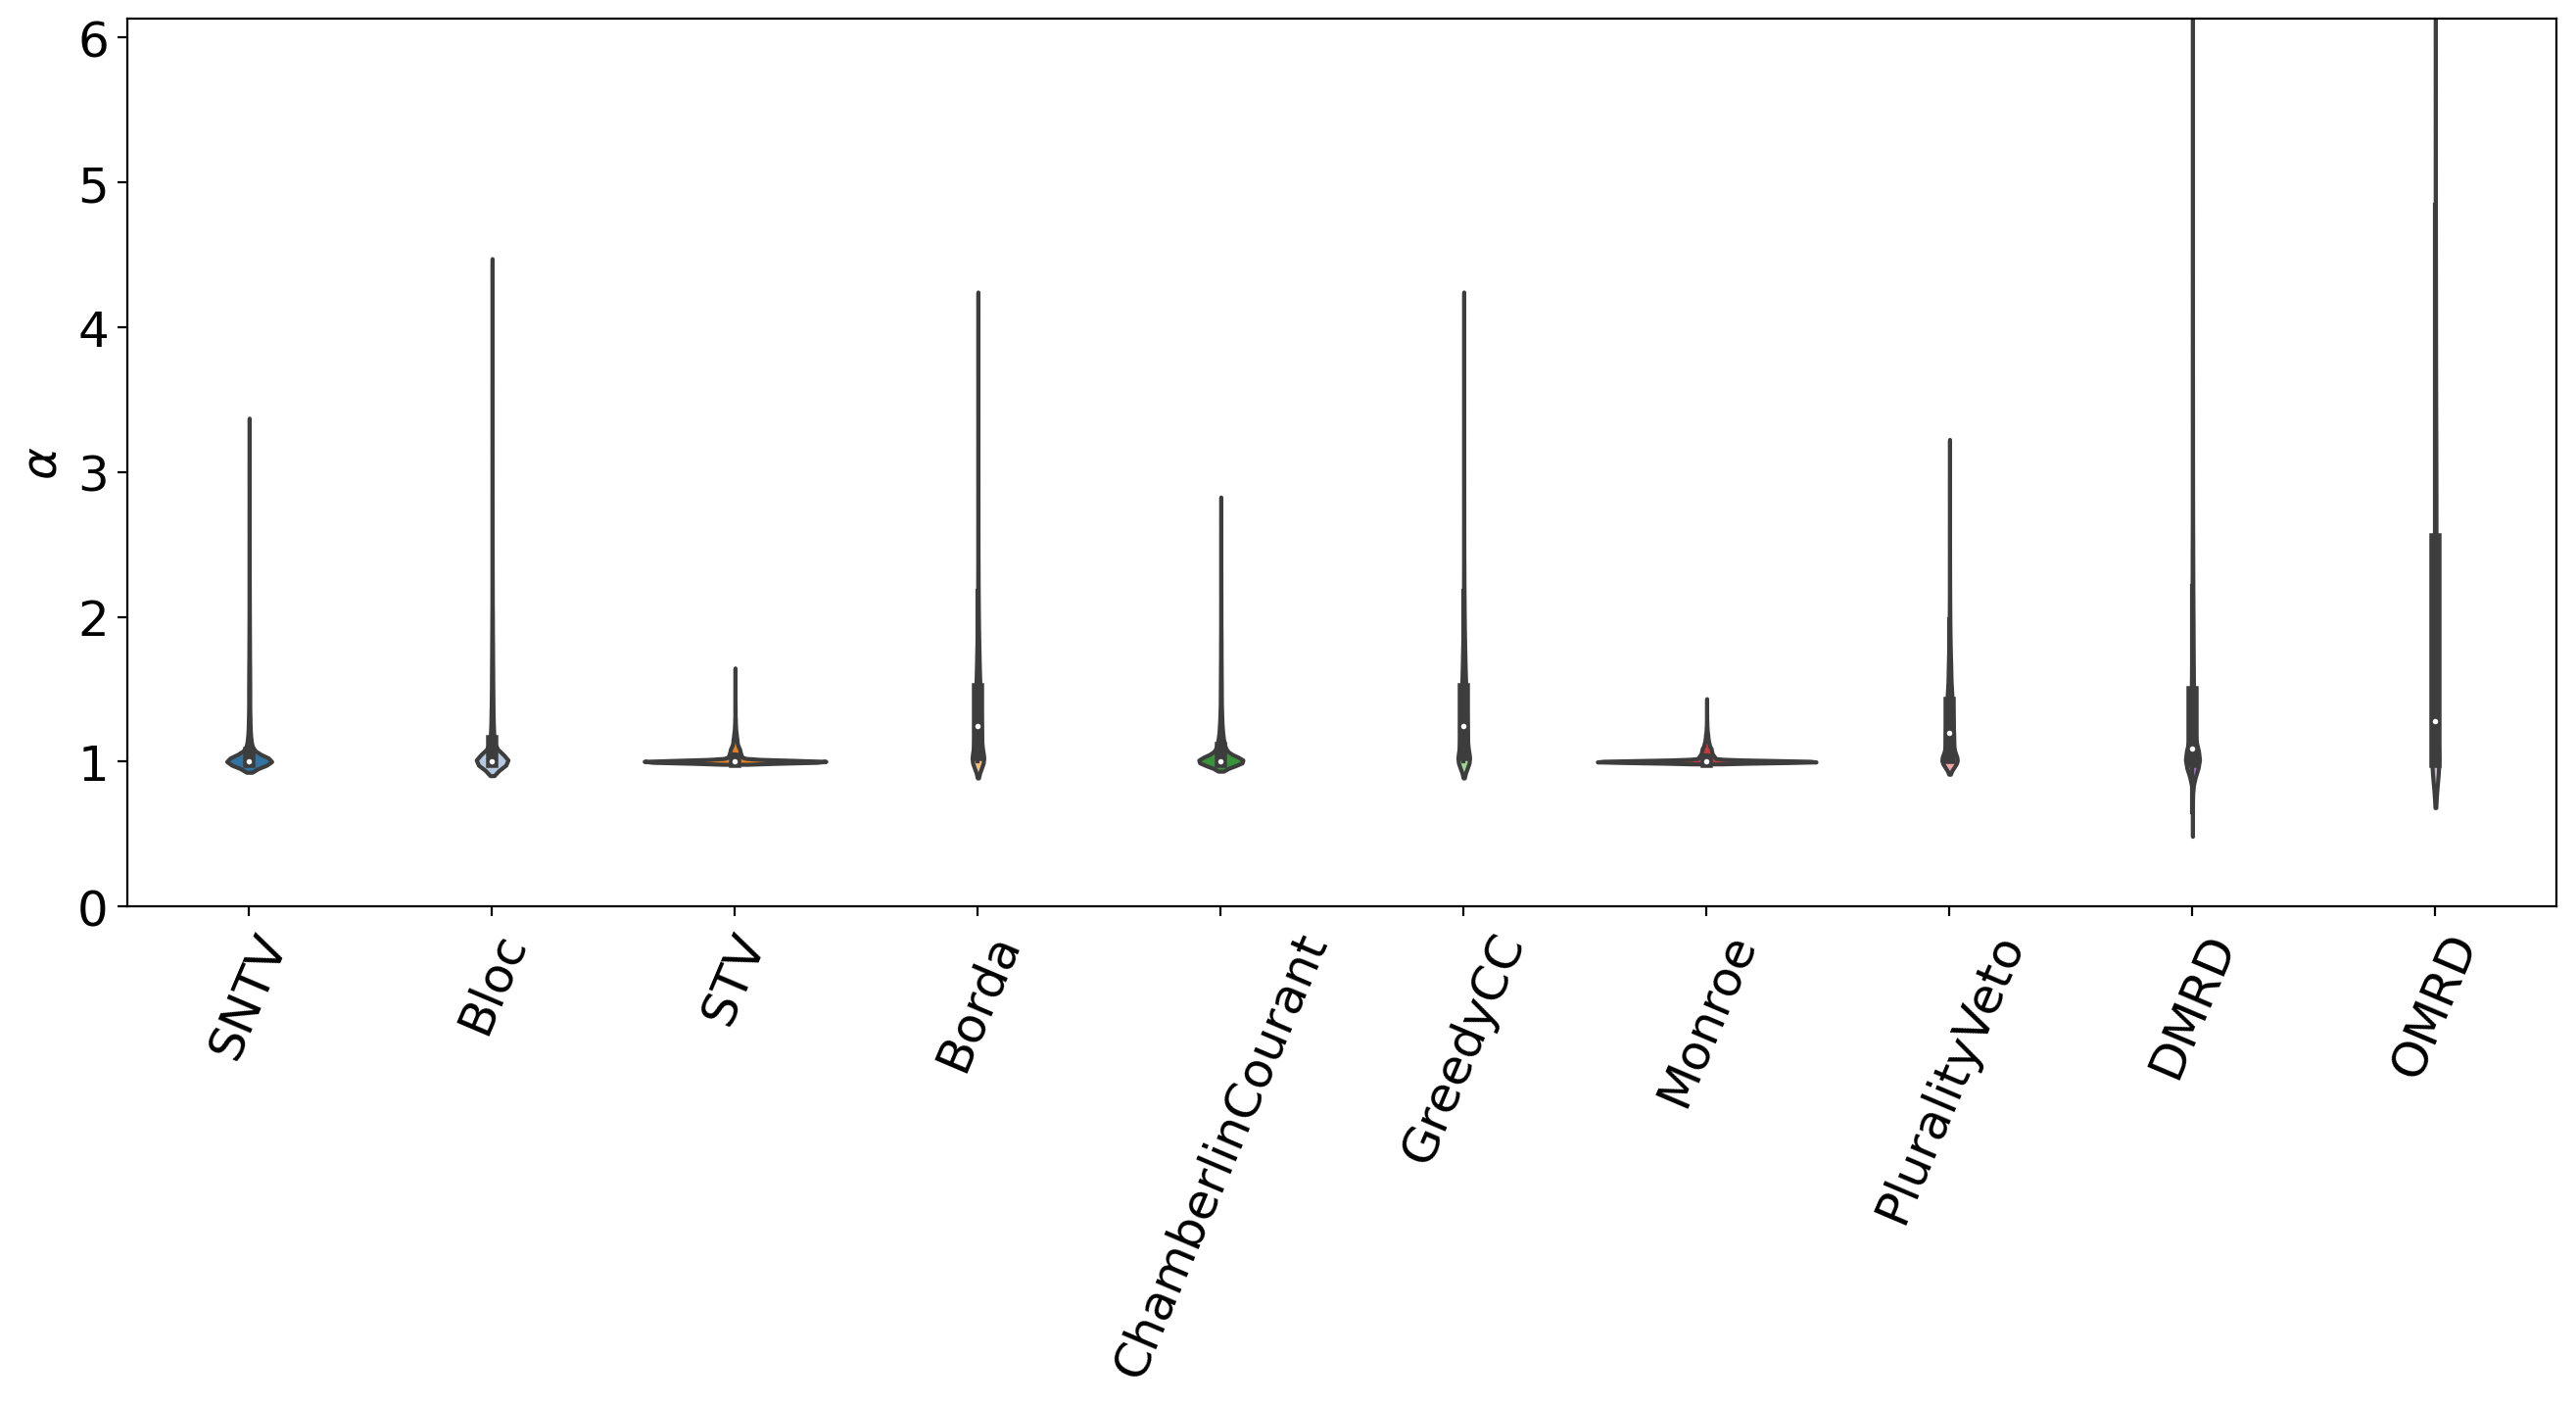

In [26]:
# Combine the arrays into a list
represent_data = [values for values in avg_represent.values()]
represent_labels = [name for name in avg_represent.keys()]

plt.rcParams.update({'font.size': 18})
# Create a violin plot
plt.figure(figsize=(16, 6), dpi = 200)
ax = sns.violinplot(data=represent_data, palette = tab20_colors, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0, ylimit)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels, rotation=67)
plt.ylabel(r'$\alpha$')
#plt.savefig('figures/2party_representation2.png', bbox_inches='tight')
plt.show()

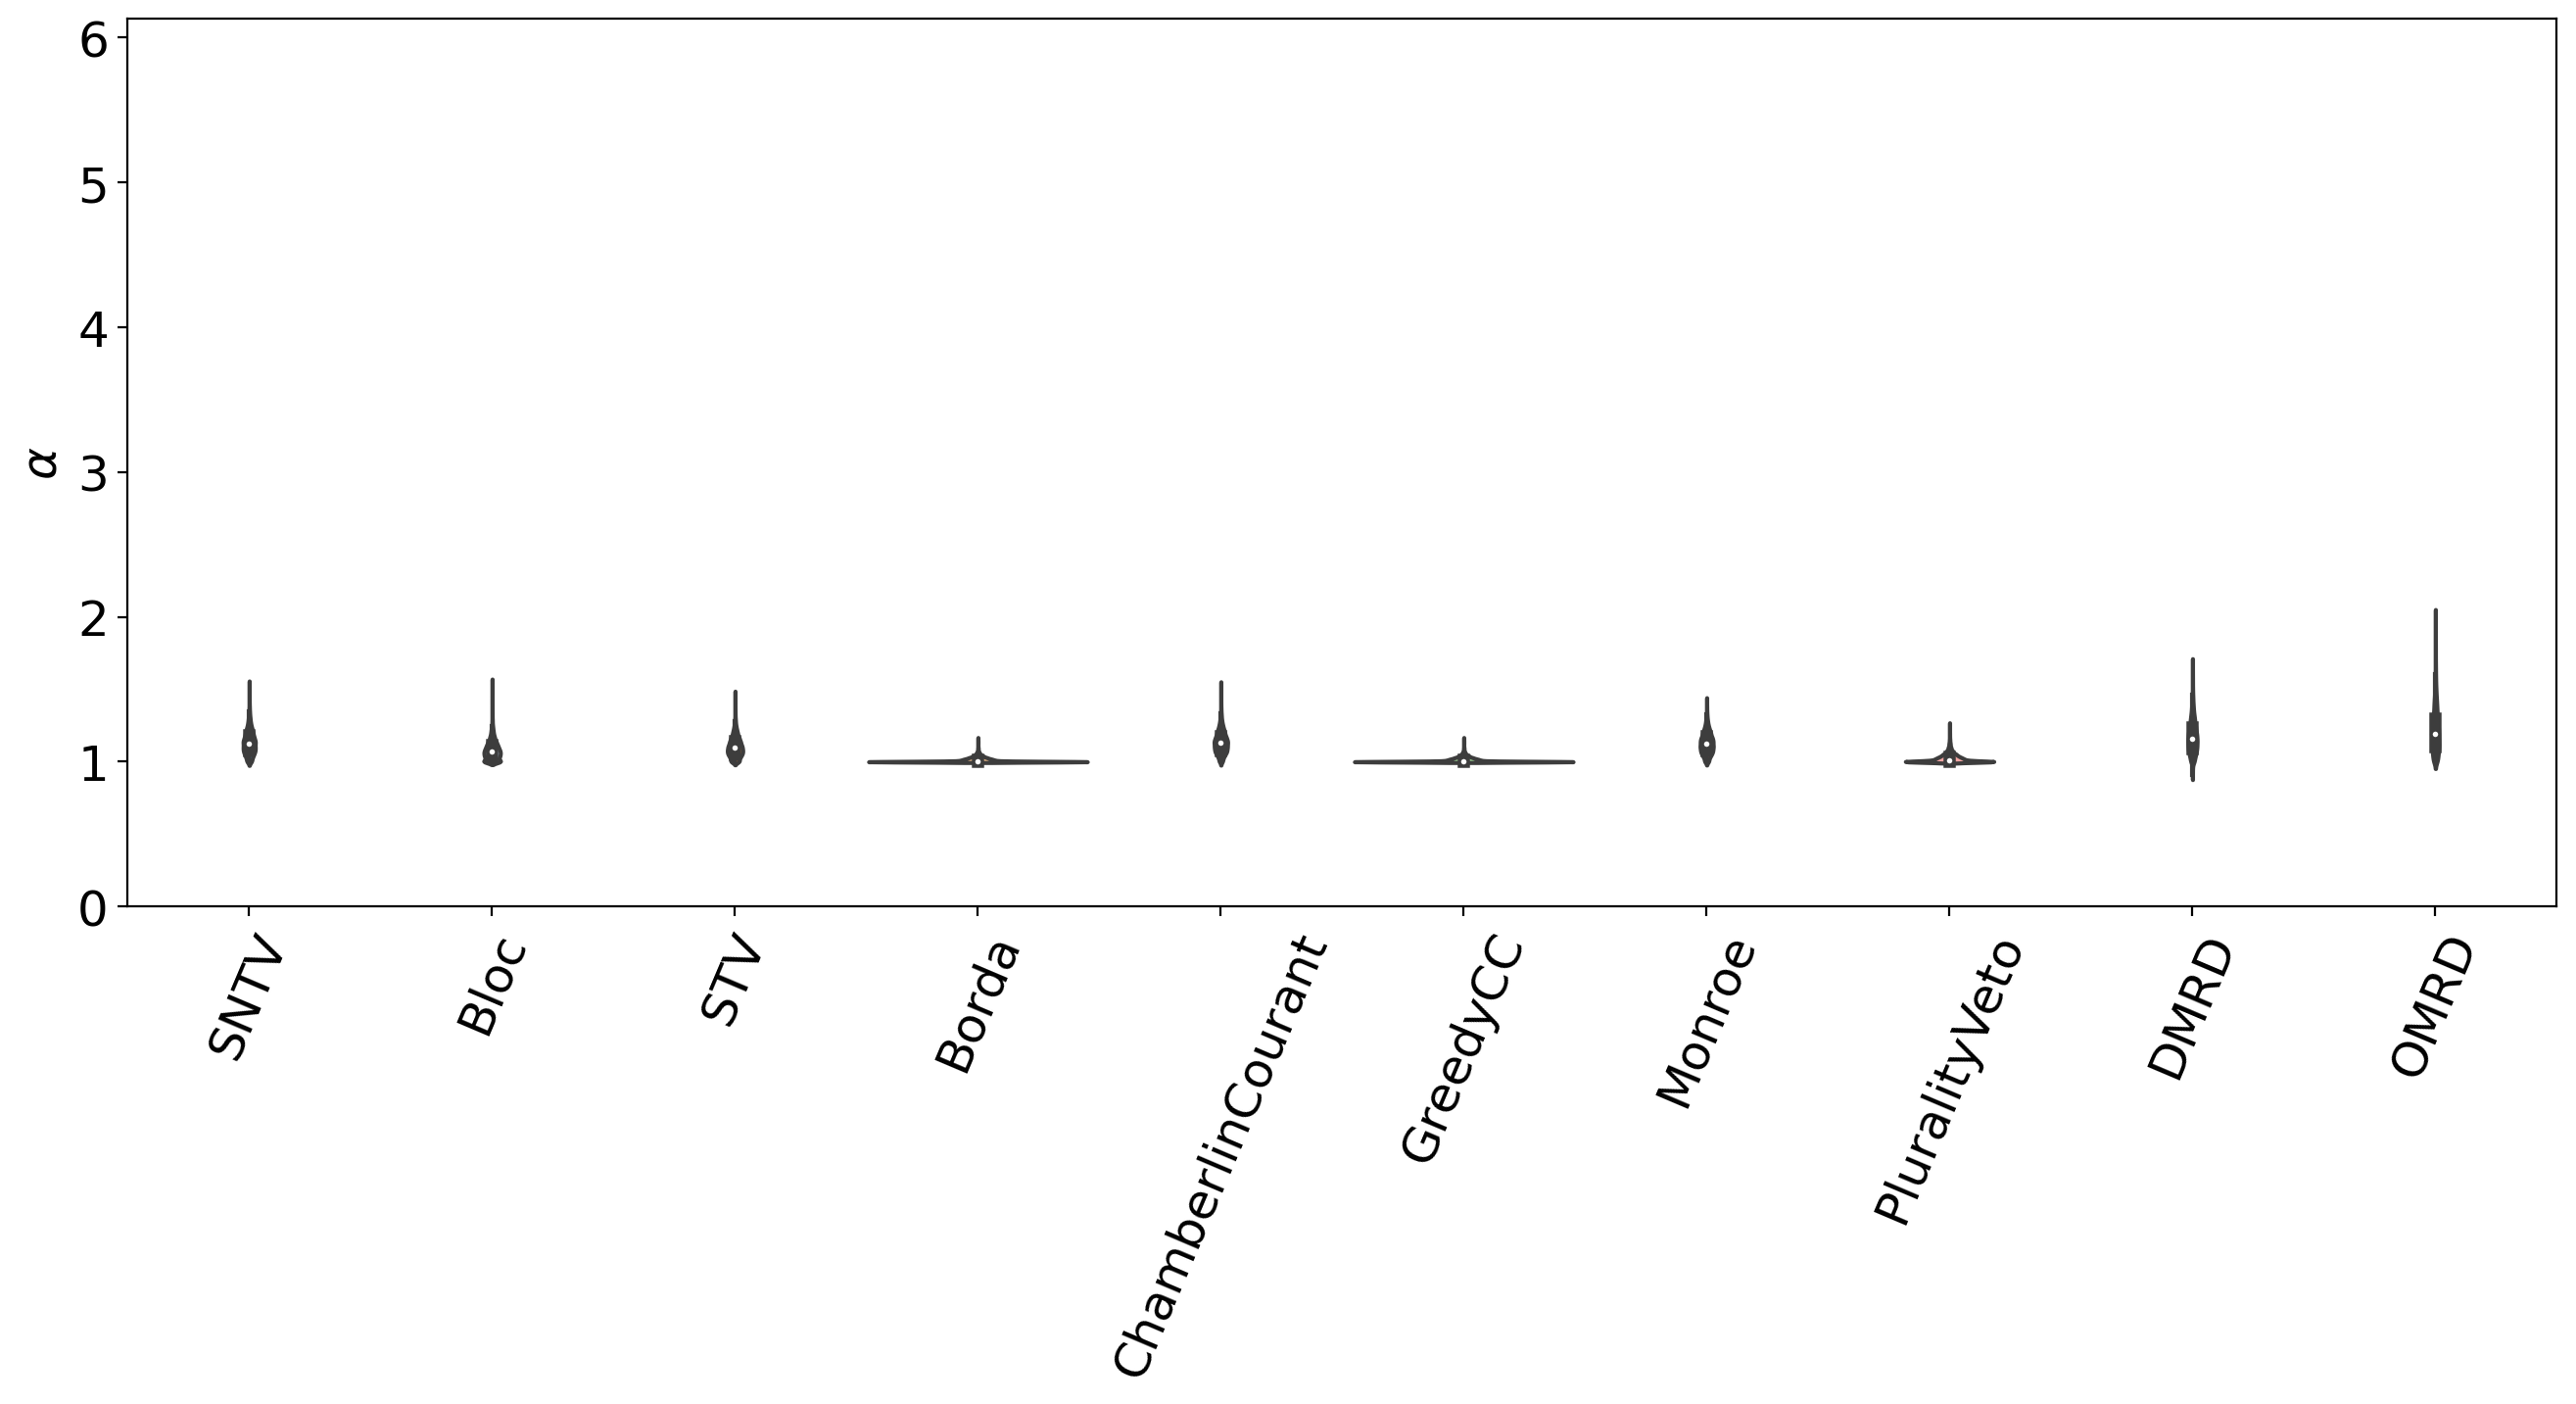

In [27]:
plt.rcParams.update({'font.size': 18})
# Create a violin plot
plt.figure(figsize=(16, 6), dpi = 200)
ax = sns.violinplot(data=represent_data1, palette = tab20_colors, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0, ylimit)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels1, rotation=67)
plt.ylabel(r'$\alpha$')
#plt.savefig('figures/2party_representation2.png', bbox_inches='tight')
plt.show()

### Changing Group Sizes

In [31]:
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{}, ChamberlinCourant:{}, GreedyCC:{}, Monroe:{},
                  RandomDictator:{'rho': 0.5}, RandomDictator2:{}, PluralityVeto:{}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe, PluralityVeto,
                  RandomDictator,RandomDictator2]
n_samples = 1000

In [53]:
len([[i, 100 - i] for i in range(50, -1, -5)])

11

In [34]:
group_sizes = [[i, 100 - i] for i in range(50, -1, -5)]
group_select = 0
num_sizes = len(group_sizes)

size_avg_represent = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}
size_avg_represent['DMRD'] = size_avg_represent.pop('RandomDictator')
size_avg_represent['OMRD'] = size_avg_represent.pop('RandomDictator2')

for s in range(num_sizes):
    f = 'data/2sizes' + str(s) + '.npz'
    loaded_data = np.load(f)
    result_dict = {key: loaded_data[key] for key in loaded_data.files}
    result_dict['DMRD'] = result_dict.pop('RandomDictator')
    result_dict['OMRD'] = result_dict.pop('RandomDictator2')
    
    s_avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
    s_avg_represent['DMRD'] = s_avg_represent.pop('RandomDictator')
    s_avg_represent['OMRD'] = s_avg_represent.pop('RandomDictator2')
    
    for i in range(n_samples):
        voter_positions = result_dict['voters'][i]
        candidate_positions = result_dict['candidates'][i]
        labels = result_dict['labels'][i]

        for j,E in enumerate(elections_list):
            name = E.__name__
            if name == 'RandomDictator':
                name = 'DMRD'
            elif name == 'RandomDictator2':
                name = 'OMRD'
                
            winners = result_dict[name][i]
            represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
            s_avg_represent[name][i] = represent
            
    for ename, evals in s_avg_represent.items():
        size_avg_represent[ename][0][s] = np.mean(evals)
        size_avg_represent[ename][1][s] = np.std(evals)

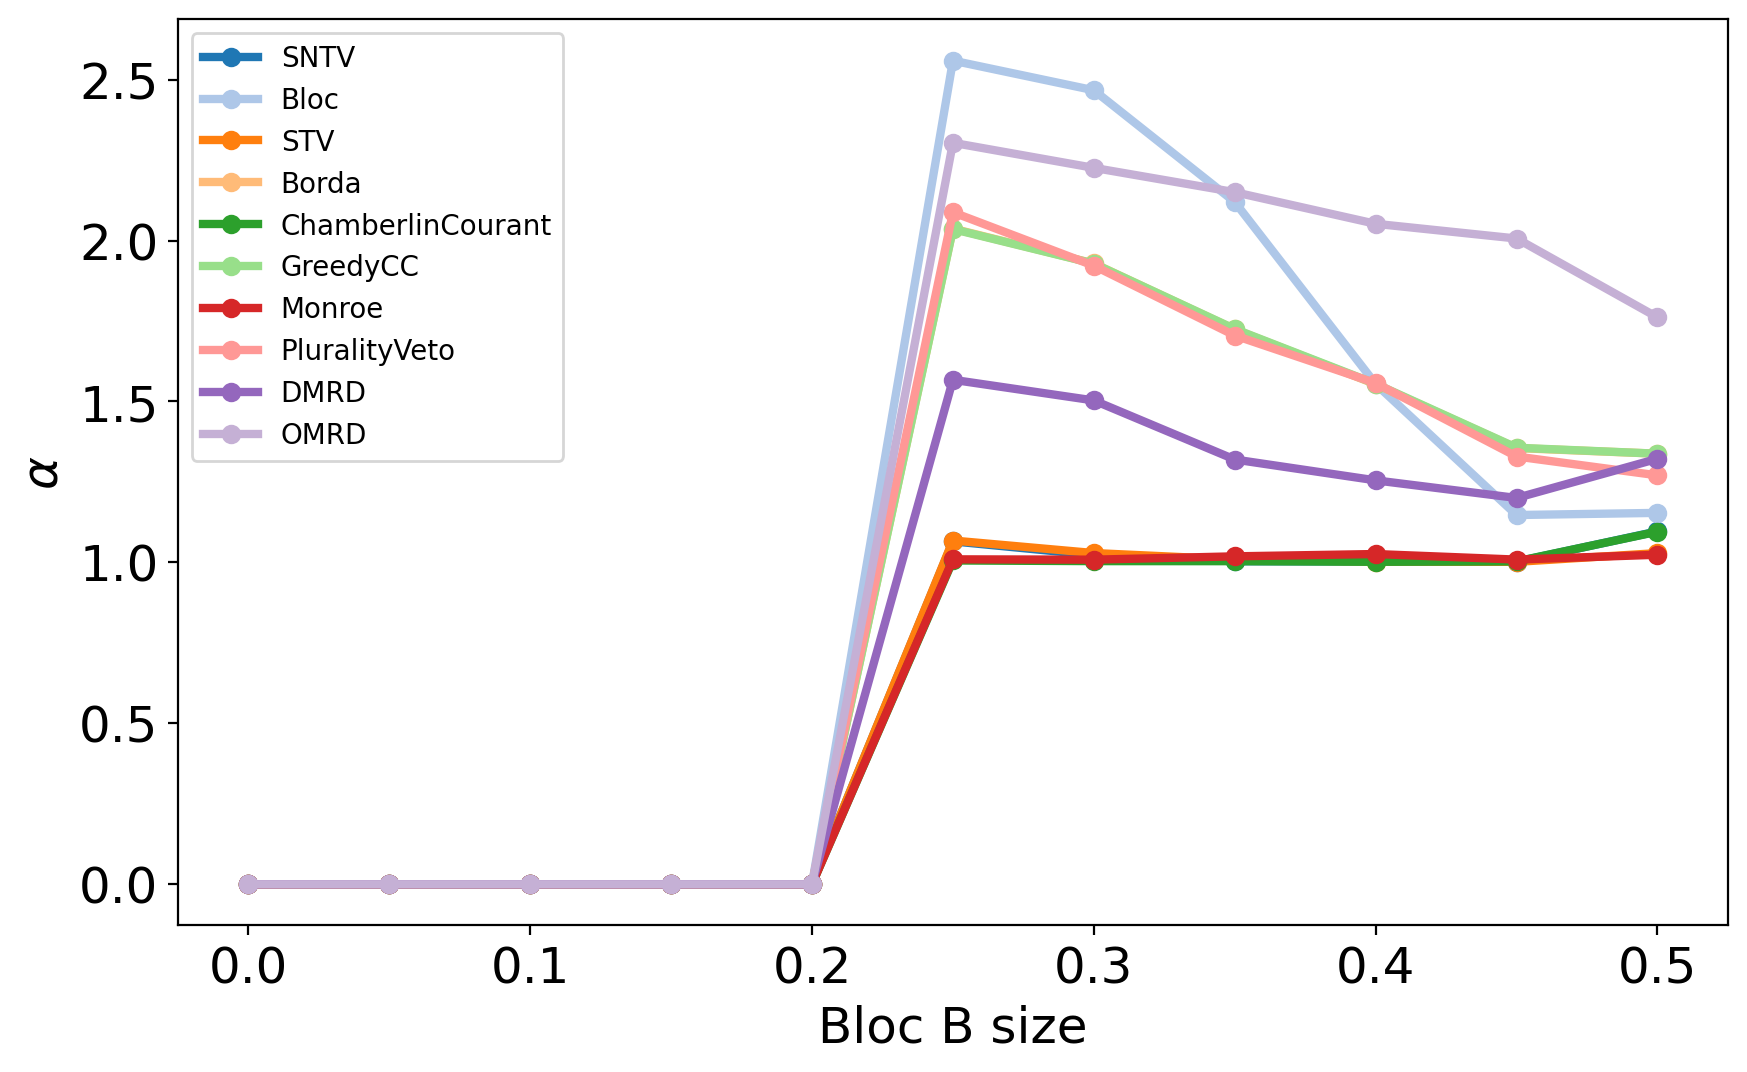

In [38]:
plt.rcParams.update({'font.size': 18})
tab20_colors = plt.cm.tab20.colors

fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [1 - x[1]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent.items()):
    ax.plot(Asizes, evals[0], label=ename, color = tab20_colors[i], linewidth = 3, marker = 'o')
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel(r'$\alpha$')
plt.xlabel('Bloc B size')
plt.legend(fontsize = 10, loc = 'upper left')
plt.savefig('figures/2party_sizes.png', bbox_inches='tight')
plt.show()

In [29]:
group_sizes = [[i, 100 - i] for i in range(50, -1, -5)]
num_sizes = len(group_sizes)

size_avg_represent1 = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}
size_avg_represent_ratio1 = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}

for s in range(num_sizes):
    f = 'data/2sizes' + str(s) + '.npz'
    loaded_data = np.load(f)
    result_dict = {key: loaded_data[key] for key in loaded_data.files}
    
    s_avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
    s_avg_represent_ratio = {e.__name__:np.zeros(n_samples) for e in elections_list}
    
    for i in range(n_samples):
        voter_positions = result_dict['voters'][i]
        candidate_positions = result_dict['candidates'][i]
        labels = result_dict['labels'][i]
        labels = np.zeros(len(labels))

        for j,E in enumerate(elections_list):
            name = E.__name__
            winners = result_dict[name][i]
            represent = representativeness(voter_positions, candidate_positions, labels, winners)
            represent_ratio = representativeness_ratio(voter_positions, candidate_positions, labels, winners)
            s_avg_represent[name][i] = represent
            s_avg_represent_ratio[name][i] = represent_ratio
            
    for ename, evals in s_avg_represent.items():
        size_avg_represent1[ename][0][s] = np.mean(evals)
        size_avg_represent1[ename][1][s] = np.std(evals)
        
    for ename, evals in s_avg_represent_ratio.items():
        size_avg_represent_ratio1[ename][0][s] = np.mean(evals)
        size_avg_represent_ratio1[ename][1][s] = np.std(evals)

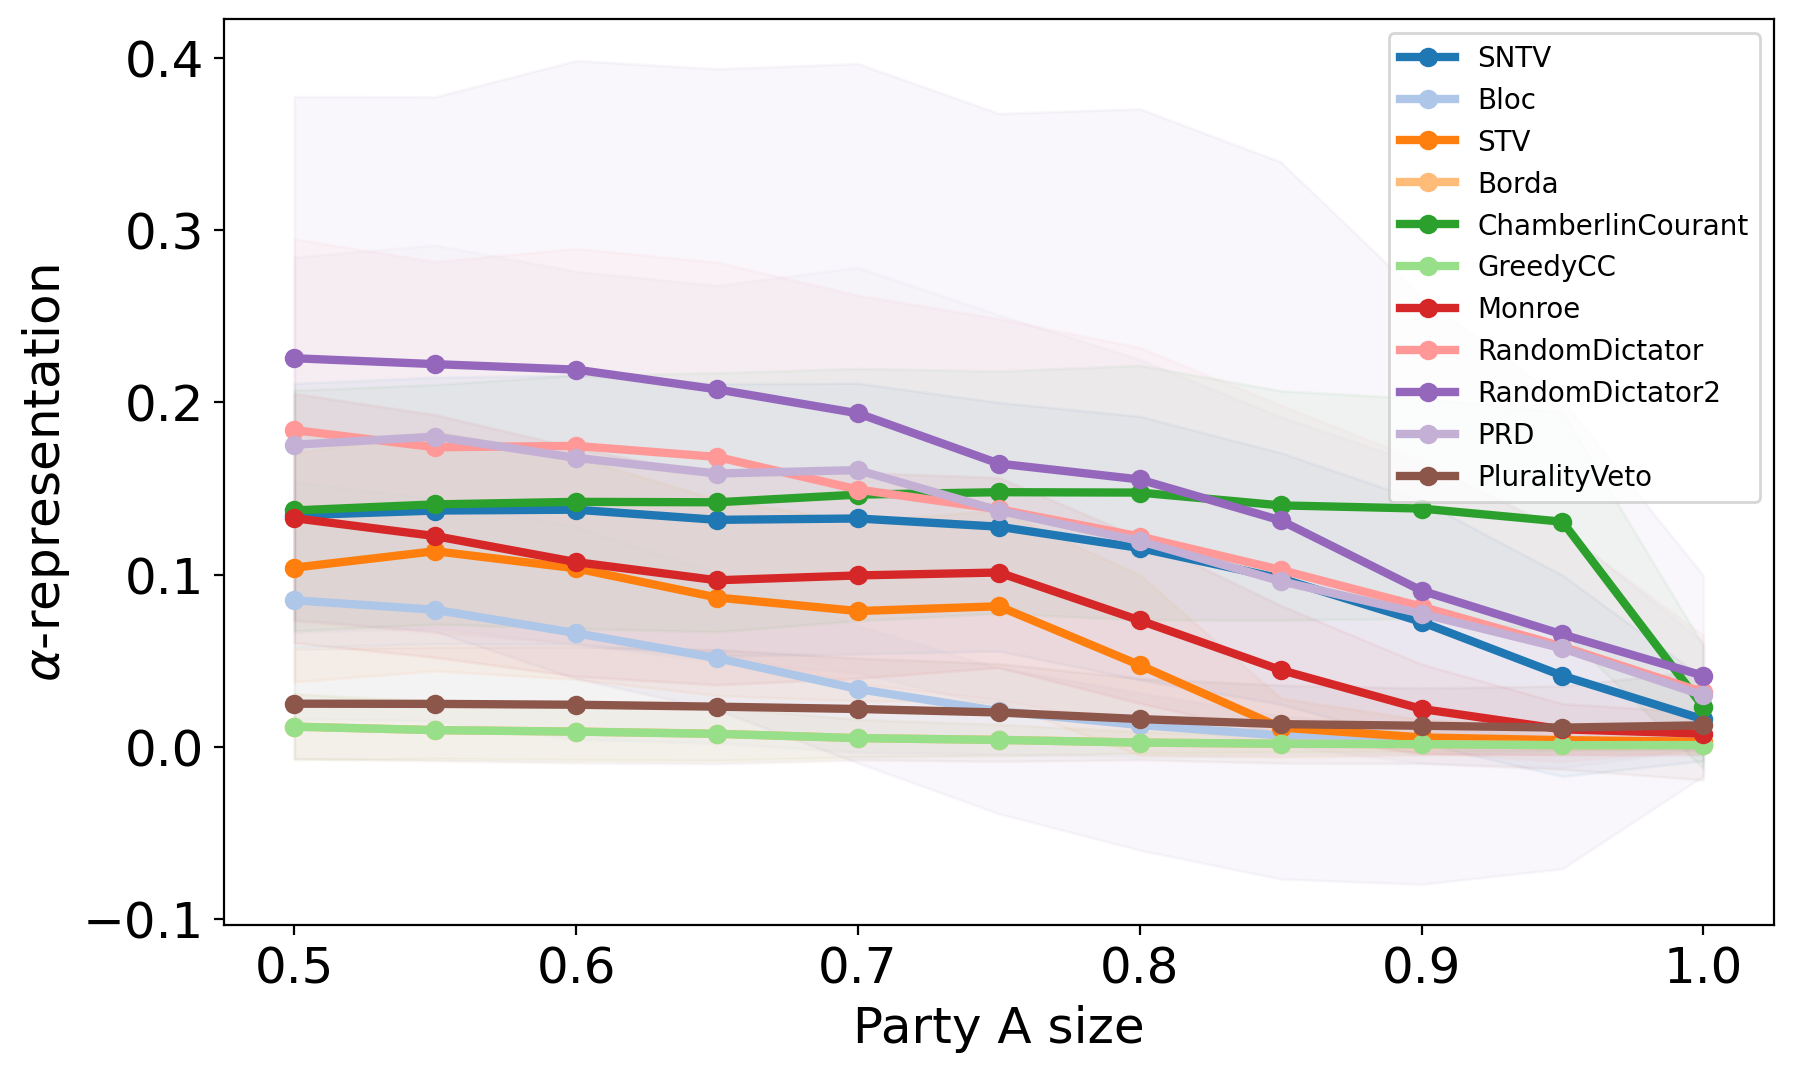

In [35]:
plt.rcParams.update({'font.size': 18})
tab20_colors = plt.cm.tab20.colors

fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[1]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent1.items()):
    ax.plot(Asizes, evals[0], label=ename, color = tab20_colors[i], linewidth = 3, marker = 'o')
    ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel(r'$\alpha$-representation')
plt.xlabel('Party A size')
plt.legend(fontsize = 10, loc = 'upper right')
#plt.savefig('figures/2party_representation.png', bbox_inches='tight')
plt.show()

### Changing Group Membership

In [ ]:
used_samples = 100
max_clusters = 20
avg_cluster_represent = {e.__name__:np.zeros((m, used_samples)) for e in elections_list}

for t in range(1,max_clusters):
    print(t)
    for i in range(used_samples):
        voter_positions = result_dict['voters'][i]
        # partition voters to groups
        kmeans = KMeans(n_clusters=t, random_state=0, n_init="auto").fit(voter_positions)
        labels = kmeans.labels_
        groups = [[j for j in range(len(labels)) if labels[j] == i] for i in np.unique(labels)]
        candidate_positions = result_dict['candidates'][i]
        
        for j,E in enumerate(elections_list):
            name = E.__name__
            winners = result_dict[name][i]
            represent = representativeness(voter_positions, candidate_positions, groups, winners)
            avg_cluster_represent[name][t-1,i] = represent

In [ ]:
fig,ax = plt.subplots(dpi = 200)
up_to = 20
for i,E in enumerate(elections_list):
    cluster_data = avg_cluster_represent[E.__name__]
    means = np.mean(cluster_data, axis=1)
    means = means[:up_to]
    std_devs = np.std(cluster_data, axis=1)
    std_devs = std_devs[:up_to]
    
    ax.plot(means, label=E.__name__, color=pal[2+i], linewidth = 3)
    ax.fill_between(range(up_to), means - std_devs, means + std_devs, color=pal[2+i], alpha=0.05)

plt.xlabel('Number of Clusters')
plt.ylabel('Epsilon')
plt.legend()
plt.savefig('figures/2party_cluster.png', bbox_inches='tight')
plt.show()